In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *

In [2]:
df_columns = ['start_time', 'startstation_latitude', 'startstation_longitude', 'endstation_latitude', 'endstation_longitude', 'birthyear', 'gender', 'year']

In [3]:
df = pd.DataFrame(columns=df_columns)

path = "data/nyc/"
for file in os.listdir(path):
    year = file[:4]
    if year.isnumeric() and int(year) < 2017:
        data = pd.read_csv(path + file)
        data.loc[:, 'year'] = int(year)
        
        data_columns = data.columns.to_numpy()[[1, 5, 6, 9, 10, 13, 14, 15]].tolist()
        data = data.loc[:, data_columns]

        data.columns = df_columns

        df = pd.concat([df, data[df_columns]])

df.year = df.year.astype('int64')

df = df.reset_index(drop=True)

In [4]:
df

,start_time,startstation_latitude,startstation_longitude,endstation_latitude,endstation_longitude,birthyear,gender,year
0,2014-01-01 00:00:06,40.711174,-73.996826,40.717290,-73.996375,1986,1,2014
1,2014-01-01 00:00:38,40.741444,-73.975361,40.701221,-74.012342,1963,1,2014
2,2014-01-01 00:03:59,40.754601,-73.971879,40.758491,-73.959206,1991,1,2014
3,2014-01-01 00:05:15,40.751884,-73.977702,40.747659,-73.984907,1989,1,2014
4,2014-01-01 00:05:18,40.683826,-73.976323,40.682166,-73.953990,1990,1,2014
...,...,...,...,...,...,...,...,...
27780019,2016-12-31 23:56:15,40.739017,-74.002638,40.730477,-73.999061,1974.0,2,2016
27780020,2016-12-31 23:56:19,40.764397,-73.973715,40.776829,-73.963888,1983.0,1,2016
27780021,2016-12-31 23:56:35,40.791976,-73.945993,40.791270,-73.964839,1970.0,2,2016
27780022,2016-12-31 23:59:31,40.771639,-73.982614,40.787209,-73.981281,1961.0,1,2016


In [5]:
np.mean(df.isna(), axis=0)

start_time                0.000000
startstation_latitude     0.000000
startstation_longitude    0.000000
endstation_latitude       0.000000
endstation_longitude      0.000000
birthyear                 0.093329
gender                    0.000000
year                      0.000000
dtype: float64

In [6]:
# remove null and non-numeric values of birthyear
# remove all birthyears before 1920
df = df.loc[pd.to_numeric(df.birthyear, errors='coerce').notnull()]
df.birthyear = df.birthyear.astype('int64')
df = df.loc[df.birthyear > 1920]

C:\Users\Ignacio\AppData\Local\Temp\ipykernel_34500\3808632092.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.birthyear = df.birthyear.astype('int64')


In [7]:
# remove invalid gender code
df = df.loc[df.gender != 0]
df.gender = df.gender.astype('int64')

In [8]:
# missing PRECINCTS_GJ
# get_precinct_id(df.startstation_latitude, df.startstation_longitude)

In [9]:
df.describe()

,startstation_latitude,startstation_longitude,endstation_latitude,endstation_longitude,birthyear,gender,year
count,2.455844e+07,2.455844e+07,2.455844e+07,2.455844e+07,2.455844e+07,2.455844e+07,2.455844e+07
mean,4.073622e+01,-7.398856e+01,4.073576e+01,-7.398852e+01,1.976909e+03,1.235978e+00,2.015087e+03
std,2.581520e-02,2.960386e-02,7.789566e-02,1.367851e-01,1.147031e+01,4.246087e-01,8.010296e-01
min,0.000000e+00,-7.402545e+01,0.000000e+00,-7.405950e+01,1.921000e+03,1.000000e+00,2.014000e+03
25%,4.072205e+01,-7.399851e+01,4.072182e+01,-7.399906e+01,1.969000e+03,1.000000e+00,2.014000e+03
50%,4.073726e+01,-7.398998e+01,4.073705e+01,-7.399003e+01,1.979000e+03,1.000000e+00,2.015000e+03
75%,4.075140e+01,-7.398042e+01,4.075097e+01,-7.398057e+01,1.986000e+03,1.000000e+00,2.016000e+03
max,4.080421e+01,0.000000e+00,4.080421e+01,0.000000e+00,2.000000e+03,2.000000e+00,2.016000e+03


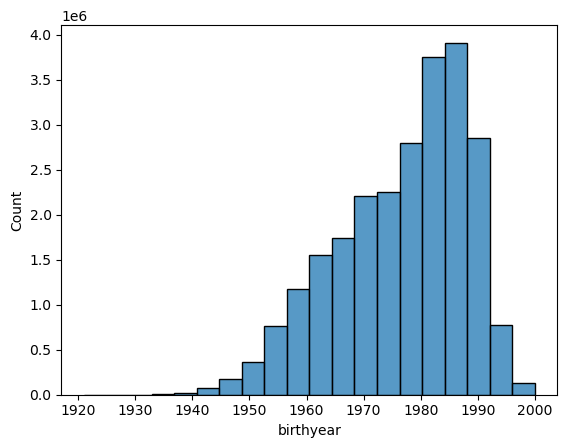

In [10]:
sns.histplot(df.birthyear, bins=20)
plt.show()

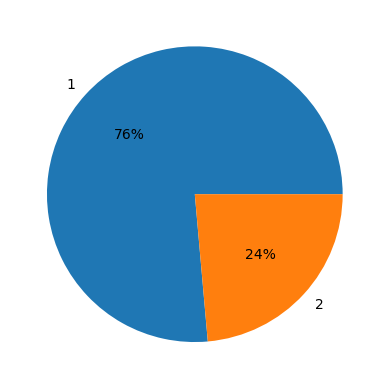

In [11]:
plt.pie([np.mean(df.gender == 1), np.mean(df.gender == 2)], labels=['1', '2'], autopct='%.0f%%')
plt.show()

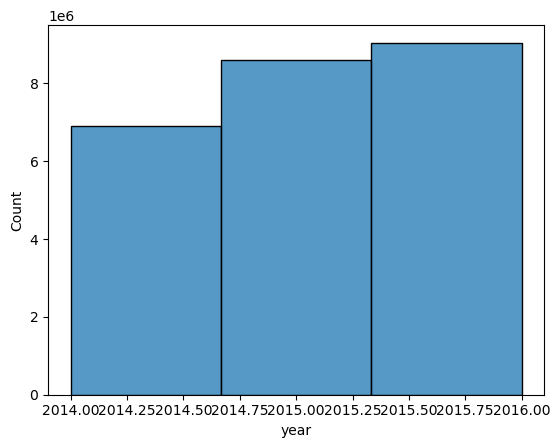

In [12]:
sns.histplot(df.year, bins=3)
plt.show()

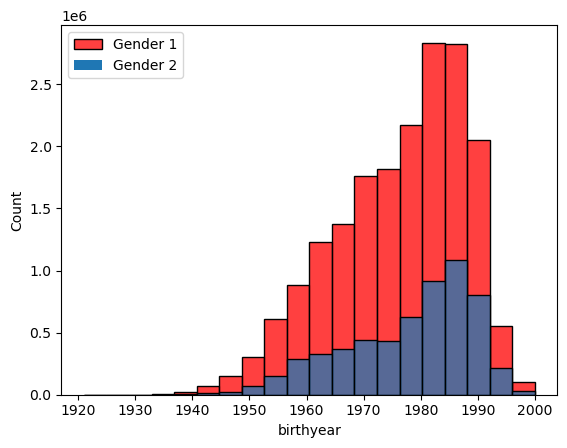

In [13]:
sns.histplot(df[df.gender == 1].birthyear, bins=20, color='r')
sns.histplot(df[df.gender == 2].birthyear, bins=20)
plt.legend(['Gender 1', 'Gender 2'])
plt.show()

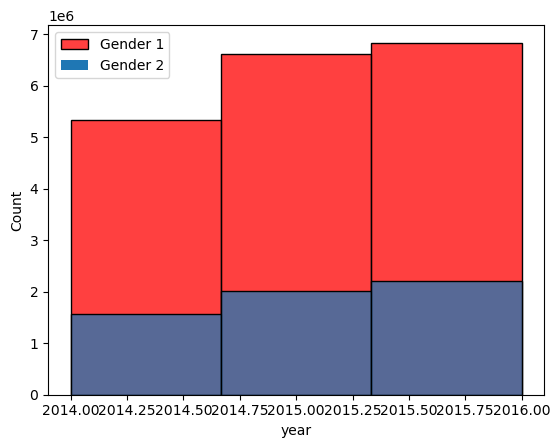

In [14]:
sns.histplot(df[df.gender == 1].year, bins=3, color='r')
sns.histplot(df[df.gender == 2].year, bins=3)
plt.legend(['Gender 1', 'Gender 2'])
plt.show()

In [15]:
df.to_pickle('citi-data.pkl')